In [17]:
import os
import numpy as np
import pandas as pd
from sklearn import tree
import pydotplus
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report

import pickle

In [18]:
formants_folder = "all_formants_observed_formants_first_5_formants"
def load_formants_from_file(file_path):
    return pd.read_csv(file_path)


In [19]:
full_data = pd.DataFrame()
for formant_file in os.listdir(formants_folder):
    full_data = full_data.append(load_formants_from_file(os.path.join(formants_folder, formant_file)), ignore_index=True)



In [20]:
phoneme_remap = {
 'sil': 'sil',
 'g': 'voiced',
 'a': 'a',
 'f': 'voiced',
 's': 'voiced',
 'n': 'voiced',
 'r': 'voiceless',
 'j': 'voiced',
 'R': 'voiced',
 'o': 'o',
 'b': 'voiced',
 'i': 'i',
 'k': 'voiceless',
 'u': 'u',
 'd': 'voiced',
 'e': 'e',
 'l': 'voiced',
 'c': 'voiceless',
 'm': 'voiced',
 't': 'voiceless',
 'p': 'voiceless',
 'y': 'voiced',
 'C': 'voiced',
 'N': 'voiced',
 '': 'voiced',
 'S': 'voiced'
}

full_data["phoneme"].replace(phoneme_remap, inplace=True)


In [21]:
sil_frames = full_data[full_data["phoneme"] == "sil"]

full_data = full_data.drop(sil_frames.index)


In [22]:
full_data['phoneme']
all_phonemes = [str(s) for s in full_data['phoneme'].unique()]


In [23]:
phonemes_grouped = full_data.groupby('phoneme')

phonemes_grouped.groups


{'a': [1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, ...], 'e': [159, 160, 161, 162, 163, 164, 165, 166, 167, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 1302, 1303, 1304, 1305, 1306, 1307, 1308,

In [24]:
phoneme_count = full_data['phoneme'].value_counts()
percentage_to_extract_test = 0.1
fixed_extra_to_test = 5

values_to_extract = (phoneme_count * percentage_to_extract_test + fixed_extra_to_test).round()
values_to_extract = values_to_extract.apply(np.int64)



In [25]:
train_set = full_data.dropna(subset=["phoneme"])
train_set[["i"]] = train_set[["i"]].fillna(value=-300)
test_set = pd.DataFrame()
for index, value in values_to_extract.items():
    sub_data_frame = train_set[train_set["phoneme"] == index]
    test_to_remove = sub_data_frame.sample(value)
    test_set = test_set.append(test_to_remove)
    train_set = train_set.drop(test_to_remove.index)

/home/ma0/miniconda3/envs/master_thesis/lib/python3.8/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [26]:
FORMANTS_TO_EXTRACT = 5
formant_names = [f"f_{i+1}" for i in range(FORMANTS_TO_EXTRACT)]

formant_names.append("i")
print(formant_names)

['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'i']


In [27]:
train_data = train_set[formant_names].fillna(train_set[formant_names].mean())


In [28]:
tree_classifier = tree.DecisionTreeClassifier(max_depth=6)
tree_classifier.fit(train_data, train_set['phoneme'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [29]:
test_data = test_set[formant_names].fillna(train_set[formant_names].mean())
predicted = tree_classifier.predict(test_data[formant_names])
score = accuracy_score(test_set["phoneme"], predicted)
score



0.6286353467561522

In [32]:
report = classification_report(test_set["phoneme"], predicted, labels=all_phonemes, digits=4)
print(report)


              precision    recall  f1-score   support

      voiced     0.6141    0.8083    0.6979       313
           e     0.6207    0.4186    0.5000        86
           o     0.5593    0.6875    0.6168       144
           u     0.6875    0.3143    0.4314        35
   voiceless     0.4444    0.1463    0.2202        82
           a     0.7316    0.7898    0.7596       176
           i     0.8571    0.2069    0.3333        58
         nan     0.0000    0.0000    0.0000         0

   micro avg     0.6286    0.6286    0.6286       894
   macro avg     0.5643    0.4215    0.4449       894
weighted avg     0.6321    0.6286    0.6000       894



/home/ma0/miniconda3/envs/master_thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ma0/miniconda3/envs/master_thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
confusion = confusion_matrix(test_set["phoneme"], predicted, labels=all_phonemes)


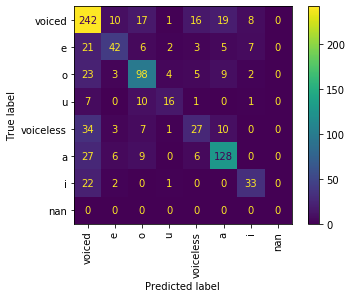

In [24]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion,
    display_labels=all_phonemes
)
disp.plot(
    # include_values=include_values,
    cmap='viridis',
    # ax=ax,
    xticks_rotation="vertical",
    values_format='g'
)

Results: 0.6957494407158836

In [20]:
base_name = "voiced_voiceless"


tree.export_graphviz(
    tree_classifier,
    out_file=f'{base_name}.dot',
    feature_names=formant_names,
    class_names=all_phonemes,
    filled=True
)

print(tree.export_text(tree_classifier))

|--- feature_0 <= 574.81
|   |--- feature_1 <= 1162.31
|   |   |--- feature_0 <= 360.25
|   |   |   |--- feature_0 <= 328.44
|   |   |   |   |--- feature_0 <= 303.49
|   |   |   |   |   |--- feature_3 <= 2729.94
|   |   |   |   |   |   |--- feature_5 <= 64.11
|   |   |   |   |   |   |   |--- feature_2 <= 1783.83
|   |   |   |   |   |   |   |   |--- class: a
|   |   |   |   |   |   |   |--- feature_2 >  1783.83
|   |   |   |   |   |   |   |   |--- class: o
|   |   |   |   |   |   |--- feature_5 >  64.11
|   |   |   |   |   |   |   |--- class: voiced
|   |   |   |   |   |--- feature_3 >  2729.94
|   |   |   |   |   |   |--- feature_0 <= 293.73
|   |   |   |   |   |   |   |--- feature_2 <= 1858.02
|   |   |   |   |   |   |   |   |--- feature_0 <= 261.88
|   |   |   |   |   |   |   |   |   |--- feature_4 <= 3695.08
|   |   |   |   |   |   |   |   |   |   |--- class: o
|   |   |   |   |   |   |   |   |   |--- feature_4 >  3695.08
|   |   |   |   |   |   |   |   |   |   |--- class: voiceless

In [21]:

graph = pydotplus.graph_from_dot_file(f'{base_name}.dot')
print(type(graph))
with open(f"{base_name}.png", "wb+") as f:
    f.write(graph.create_png())

<class 'pydotplus.graphviz.Dot'>
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.407946 to fit



In [22]:


with open(f"{base_name}.pickle", "wb+") as pickle_file:
    pickle.dump(tree_classifier, pickle_file)